# ColdFusion
### GPR-LIDAR-FUSION
7/12/22

Query the SnowEx database to extract ground based snow depth measurements, snow pit density, GPR tracks, and Lidar point clounds where there is spatial and temporal overlap in a defined area.

Use the lidar snow depth measurements to inform the GPR density estimate to get SWE.

Test these density/SWE estimates against snowpit values

In [14]:
# Imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from snowexsql.db import get_table_attributes

import datetime
from sqlalchemy import inspect
from sqlalchemy.sql import func
import shapely.geometry
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc
import pandas as pd

from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points

# Imports for Lidar raster
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

### Define Constants

In [2]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

# Define Dates
date1 = datetime.date(2020,1,29)
date2 = datetime.date(2020,2,6)

### Magnaprobe Data

In [3]:
# Instrument name 
site_name = "Grand Mesa"
instrument = "magnaprobe" 

# Get a session
engine, session = get_db(db_name)

# Find the magnaprobe PointData in the defined area within the given dates 
query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
query_mp = query_mp.filter(PointData.site_name == site_name)
# Filter by bounding box
query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# Filter by an instrument 
query_mp = query_mp.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
query_mp = query_mp.filter(PointData.date >= date1)
query_mp = query_mp.filter(PointData.date <= date2)

# Execute the query and convert to geopandas in one handy function
df_mp = query_to_geopandas(query_mp, engine) #directly pass to geopandas dataframe

# How many did were retrieved 
print(f'{len(df_mp.index)} records returned!')
print(df_mp.head())
session.close()

16556 records returned!
                             geom        easting      northing        date  \
0  POINT (745146.730 4322396.077)  745146.730339  4.322396e+06  2020-01-29   
1  POINT (745158.923 4322394.234)  745158.922634  4.322394e+06  2020-01-29   
2  POINT (745148.393 4322398.351)  745148.393097  4.322398e+06  2020-01-29   
3  POINT (745158.057 4322394.207)  745158.056693  4.322394e+06  2020-01-29   
4  POINT (745156.359 4322393.043)  745156.359374  4.322393e+06  2020-01-29   

   value   type  instrument  
0   96.0  depth  magnaprobe  
1   95.0  depth  magnaprobe  
2   94.0  depth  magnaprobe  
3  102.0  depth  magnaprobe  
4  100.0  depth  magnaprobe  


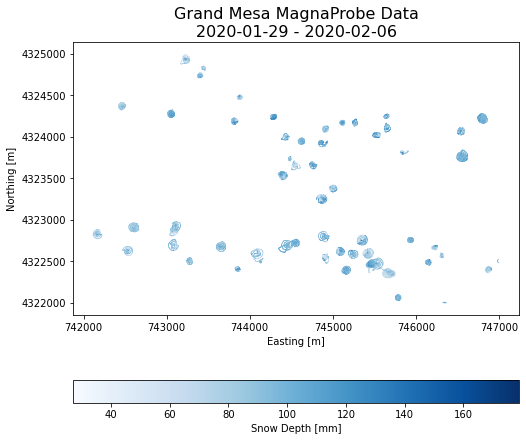

In [4]:
# Plot sites
# Build a single plot
fig, ax = plt.subplots(figsize=(8,8))

# Colorbar keyword arguments
kwds = {'label': "Snow Depth [mm]", 'orientation': "horizontal"}

# Plot it all up as a scatter using SWE as the color
ax = df_mp.plot(ax=ax, column='value', cmap='Blues', markersize=0.5, edgecolor='none', legend=True,legend_kwds=kwds)

# Set some style/ labeling choices
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

title = 'Grand Mesa MagnaProbe Data\n{} - {}'.format(df_mp['date'].min(), df_mp['date'].max())
ax.set_title(title, fontsize=16)

plt.show()

### Snow Pit measurements

In [58]:
# Start the session
engine, session = get_db(db_name)

# Find the snowpit LayerData in the defined area within given dates
query_sp = session.query(LayerData.geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                      LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query_sp = query_sp.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query_sp = query_sp.filter(LayerData.type == "density")

# Slicing the dataset for specified dates 
query_sp = query_sp.filter(LayerData.date >= date1)
query_sp = query_sp.filter(LayerData.date <= date2)

count_meas = query_sp.count() 
print(count_meas, " Snowpit density measurements returned!\n") 

# convert to pandas dataframe  
df_sp = query_to_geopandas(query_sp, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df_sp['pit_id'].unique())
count_pits = len(locations) 
print(count_pits, " Snowpit density locations returned!\n") 

session.close()

/tmp/ipykernel_89/2349984299.py:19: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  count_meas = query_sp.count()


1292  Snowpit density measurements returned!

70  Snowpit density locations returned!



In [6]:
print(df_sp)

                                geom   easting   northing        date  \
0     POINT (745529.000 4322471.000)  745529.0  4322471.0  2020-02-04   
1     POINT (745529.000 4322471.000)  745529.0  4322471.0  2020-02-04   
2     POINT (745529.000 4322471.000)  745529.0  4322471.0  2020-02-04   
3     POINT (745529.000 4322471.000)  745529.0  4322471.0  2020-02-04   
4     POINT (745529.000 4322471.000)  745529.0  4322471.0  2020-02-04   
...                              ...       ...        ...         ...   
1287  POINT (743109.000 4322924.000)  743109.0  4322924.0  2020-02-01   
1288  POINT (743109.000 4322924.000)  743109.0  4322924.0  2020-02-01   
1289  POINT (743109.000 4322924.000)  743109.0  4322924.0  2020-02-01   
1290  POINT (743109.000 4322924.000)  743109.0  4322924.0  2020-02-01   
1291  POINT (743109.000 4322924.000)  743109.0  4322924.0  2020-02-01   

                   value             pit_id     type instrument  
0     213.33333333333331  COGM3S33_20200204  density     

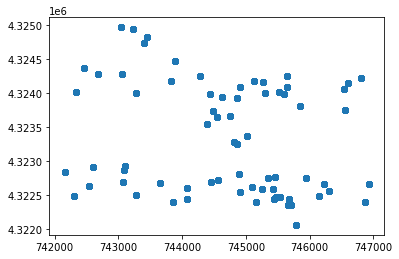

In [7]:
# Plot sites
plt.scatter(df_sp['easting'], df_sp['northing'])

In [59]:
# Average Snowpit density measurements
# Request the average (avg) of Layer data casted as a float. We have to cast to a float in the layer table because all main values are stored as a string to
# ...accommodate the hand hardness.
print(df_sp.columns)
df_sp['value'] = df_sp['value'].astype(float)
avgrho_sp = df_sp[['easting', 'northing', 'value', 'pit_id']]
avgrho_sp = df_sp.groupby(by = ['pit_id','date']).mean()
print(avgrho_sp.head())
print(len(avgrho_sp))

temp_df = df_sp[['geom', 'pit_id']]
avgrho_sp_geom = pd.merge(avgrho_sp, 
                      temp_df, 
                      on ='pit_id',
                      how ='right')

print(avgrho_sp_geom.head())
print(len(avgrho_sp_geom))

Index(['geom', 'easting', 'northing', 'date', 'value', 'pit_id', 'type',
       'instrument'],
      dtype='object')
                               easting   northing       value
pit_id            date                                       
COGM1N20_20200205 2020-02-05  743281.0  4324005.0  230.750000
COGM1S13_20200205 2020-02-05  743277.0  4322508.0  320.312500
COGM1S8_20200201  2020-02-01  742607.0  4322917.0  261.023810
COGM2C33_20200130 2020-01-30  745787.0  4322066.0  278.823529
COGM2N12_20200131 2020-01-31  742466.0  4324372.0  263.938596
70
              pit_id   easting   northing       value  \
0  COGM3S33_20200204  745529.0  4322471.0  291.216667   
1  COGM3S33_20200204  745529.0  4322471.0  291.216667   
2  COGM3S33_20200204  745529.0  4322471.0  291.216667   
3  COGM3S33_20200204  745529.0  4322471.0  291.216667   
4  COGM3S33_20200204  745529.0  4322471.0  291.216667   

                             geom  
0  POINT (745529.000 4322471.000)  
1  POINT (745529.000 4322471.00

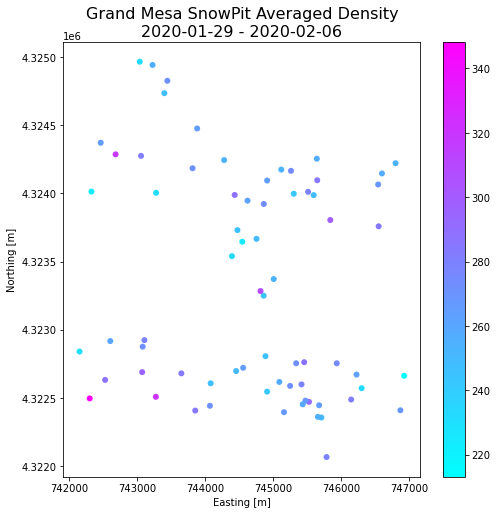

In [9]:
# Plot the sites with their average densities
fig, ax = plt.subplots(figsize=(8,8))
im = plt.scatter(x=avgrho_sp['easting'], y=avgrho_sp['northing'], c=avgrho_sp['value'], cmap='cool',edgecolor='none')
plt.colorbar(im, ax=ax)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
title = 'Grand Mesa SnowPit Averaged Density\n{} - {}'.format(df_sp['date'].min(), df_sp['date'].max())
ax.set_title(title, fontsize=16)
plt.show()

### GPR Data

### Read in the GPR Data from CSV

In [21]:
GPR = pd.read_csv('GPRLiDAR2.csv')
GPR.head()

,ASO_IDX,twt,ASO_X,ASO_Y,ASO_2020_02_13_SD,ASO_2020_02_13_SWE,date,v,e,dens,SWE,ASO_2020_02_13_dens
0,"x_idx=1000,y_idx=1002",8.0,745006.500002,4.321999e+06,NaN,NaN,2020-02-04,NaN,NaN,603.765594,NaN,NaN
1,"x_idx=1000,y_idx=1008",7.8,745024.500002,4.321999e+06,NaN,NaN,2020-02-04,NaN,NaN,561.890860,NaN,NaN
2,"x_idx=1000,y_idx=1009",9.1,745027.500002,4.321999e+06,NaN,NaN,2020-02-04,NaN,NaN,571.102489,NaN,NaN
3,"x_idx=1000,y_idx=1010",9.1,745030.500002,4.321999e+06,NaN,NaN,2020-02-04,NaN,NaN,580.139344,NaN,NaN
4,"x_idx=1000,y_idx=1011",8.0,745033.500002,4.321999e+06,NaN,NaN,2020-02-04,NaN,NaN,569.408093,NaN,NaN


In [15]:
#GPR_geo = gpd.GeoDataFrame(GPR, geometry='geom')
geom_list = [Point(xy) for xy in zip(GPR['northing'], GPR['easting'])]
GPR = GPR.drop(['easting', 'northing', 'geom'], axis=1)
gdf = gpd.GeoDataFrame(GPR, geometry=geom_list)

gdf.head()

,Unnamed: 0,twt,date,geometry
0,0,8.3,2020-01-28,POINT (4324346.715 743148.428)
1,1,8.3,2020-01-28,POINT (4324346.714 743148.404)
2,2,8.3,2020-01-28,POINT (4324346.702 743148.291)
3,3,8.3,2020-01-28,POINT (4324346.713 743148.382)
4,4,8.3,2020-01-28,POINT (4324346.711 743148.361)


Unnamed: 0               int64
easting                float64
northing               float64
twt                    float64
date                    object
geometry              geometry
ASO_IDX                 object
ASO_X                  float64
ASO_Y                  float64
ASO_2020_02_02_SD      float64
ASO_2020_02_13_SD      float64
ASO_2020_02_02_SWE     float64
ASO_2020_02_13_SWE     float64
dtype: object


<AxesSubplot:>

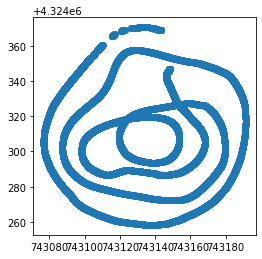

In [16]:
df= pd.read_csv("GPR_AND_ASO_ALL_FIXED.csv")
gdf = gpd.GeoDataFrame(df)
gdf.geometry = gpd.points_from_xy(gdf["easting"], gdf["northing"]) # set to GPR x,y right now
print(gdf.dtypes) # check that floats are floats
gdf.head(10000).plot() # should see spiral

In [60]:
### Get the Distance of snowPit to GPR
#GPR_Subset=GPR.iloc[0:100]
#SP_Subset=avgrho_sp_geom.iloc[0]

multipoint = gdf.geometry.unary_union
print(SP_Subset['geom'])
queried_geom, nearest_geom = nearest_points(SP_Subset['geom'], multipoint)
print(queried_geom, nearest_geom)

AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column ('geometry') is not present. 
There are no existing columns with geometry data type. You can add a geometry column as the active geometry column with df.set_geometry. 

In [61]:
SP_df_new = SP_Subset.loc[gdf['geometry'] == nearest_geom]
GPR_df_new = gdf.loc[gdf['geometry'] == nearest_geom]
print(SP_df_new)
print(df_new)

KeyError: 'geometry'

In [20]:
import scipy.spatial as spatial

In [62]:
print(avgrho_sp)
print(gdf)

                               easting   northing       value
pit_id            date                                       
COGM1N20_20200205 2020-02-05  743281.0  4324005.0  230.750000
COGM1S13_20200205 2020-02-05  743277.0  4322508.0  320.312500
COGM1S8_20200201  2020-02-01  742607.0  4322917.0  261.023810
COGM2C33_20200130 2020-01-30  745787.0  4322066.0  278.823529
COGM2N12_20200131 2020-01-31  742466.0  4324372.0  263.938596
...                                ...        ...         ...
COGM9N43_20200204 2020-02-04  745650.0  4324097.0  285.000000
COGM9N44_20200201 2020-02-01  745842.0  4323805.0  298.380952
COGM9N47_20200204 2020-02-04  746602.0  4324147.0  257.888889
COGM9S39_20200201 2020-02-01  746228.0  4322671.0  262.800000
COGM9S40_20200201 2020-02-01  746303.0  4322571.0  233.062500

[70 rows x 3 columns]
                     ASO_IDX  twt          ASO_X         ASO_Y  \
0      x_idx=1000,y_idx=1002  8.0  745006.500002  4.321999e+06   
1      x_idx=1000,y_idx=1008  7.8  7450

In [133]:
GPR = pd.read_csv('GPRLiDAR2.csv')
GPR.head()
gdf = gpd.GeoDataFrame(GPR)
SP_Subset=avgrho_sp

points = np.array((gdf["ASO_X"],gdf["ASO_Y"]))
points = points.transpose()
point_tree = spatial.cKDTree(points)
#print(point_tree)
buffer = 25 ## 25 meters

SP_pt = np.array((SP_Subset['easting'],SP_Subset['northing']))
SP_pt = SP_pt.transpose()
    
SP_Subset["GPR_Density_Averaged"] = np.nan
for i in range(len(SP_Subset)-2):
    SP_pt_temp = [SP_pt[i,0], SP_pt[i,1]]
    out = point_tree.query_ball_point(SP_pt_temp, 25)
    SP_Subset.loc[SP_Subset.index[i], 'GPR_Density_Averaged'] = gdf.iloc[out]['dens'].mean()
print(SP_Subset)



                               easting   northing       value  \
pit_id            date                                          
COGM1N20_20200205 2020-02-05  743281.0  4324005.0  230.750000   
COGM1S13_20200205 2020-02-05  743277.0  4322508.0  320.312500   
COGM1S8_20200201  2020-02-01  742607.0  4322917.0  261.023810   
COGM2C33_20200130 2020-01-30  745787.0  4322066.0  278.823529   
COGM2N12_20200131 2020-01-31  742466.0  4324372.0  263.938596   
...                                ...        ...         ...   
COGM9N43_20200204 2020-02-04  745650.0  4324097.0  285.000000   
COGM9N44_20200201 2020-02-01  745842.0  4323805.0  298.380952   
COGM9N47_20200204 2020-02-04  746602.0  4324147.0  257.888889   
COGM9S39_20200201 2020-02-01  746228.0  4322671.0  262.800000   
COGM9S40_20200201 2020-02-01  746303.0  4322571.0  233.062500   

                              GPR_Density_Averaged  
pit_id            date                              
COGM1N20_20200205 2020-02-05                   N

In [121]:
SP_pt = np.array((SP_Subset['easting'],SP_Subset['northing']))
SP_pt = SP_pt.transpose()


temp = [SP_pt[0,0], SP_pt[0,1]]
print(temp)


[743281.0, 4324005.0]


### Lidar Raster (In-Progress)

In [12]:
# Start the session
engine, session = get_db(db_name)

query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

session.close()

[('meters',)]
